In [1]:
from keras.models import Sequential
"""Import from keras_preprocessing not from keras.preprocessing, because Keras may or maynot contain the features discussed here depending upon when you read this article, until the keras_preprocessed library is updated in Keras use the github version."""
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
#from tensorflow.keras import optimizers #., optimizers
import pandas as pd
import numpy as np

import tensorflow as tf


#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image

In [2]:
def load_data_path(train_data_path, val_data_path, test_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_val_test = ['train', 'val', 'test']
    data_path = [train_data_path, val_data_path, test_data_path]
      
    for i in range(len(data_path)):

        data_list[train_val_test[i]] = []
        
        which_data_path = data_path[i]
        t1 = 0
        t2 = 0
        t2dot = 0
        tr = 0
        te = 0
        alfa = 0
        for fname in sorted(os.listdir(which_data_path + '/images')):
            if fname != ".DS_Store":

            
                subject_data_path = os.path.join(which_data_path + '/images', fname)
                     
                if not os.path.isfile(subject_data_path): continue 
            
          #  im_frame = Image.open(subject_data_path)

            #get information from text file
            # this will return a tuple of root and extension
                split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
                file_name = split_tup[0]
                file_path = os.path.join(which_data_path + '/texts', file_name) + '.txt'
                f = open(os.path.join(which_data_path + '/texts', file_name) + '.txt', 'r')
                line = f.readlines()[1]
            
                fields = line.split(',')
                t1 = float(fields[0])
                t2 = float(fields[1])
                t2dot = float(fields[2])
                tr = int(fields[3])
                te = int(fields[4])
                alfa = int(fields[5])
                f.close()
                
            # the first 5 slices are mostly noise so it is better to exlude them
                data_list[train_val_test[i]] += [(fname, t2)]
    
    return data_list

In [3]:
data_list = load_data_path ("data/train", "data/val", "data/test")

In [4]:
train_data = data_list['train']
val_data = data_list['val']
test_data = data_list['val']

In [5]:
train_df = pd.DataFrame(train_data, columns=['fnames', 'labels'])
train_df['labels']= train_df['labels'].astype(float)
train_df['labels'] = round(train_df['labels'], 3)
train_df['labels']= train_df['labels'].astype(str)
train_df['fnames']= train_df['fnames'].astype(str)
val_df = pd.DataFrame(val_data, columns=['fnames', 'labels'])
val_df['labels']= val_df['labels'].astype(float)
val_df['labels'] = round(val_df['labels'], 3)
val_df['labels']= val_df['labels'].astype(str)
val_df['fnames']= val_df['fnames'].astype(str)
test_df = pd.DataFrame(test_data, columns=['fnames', 'labels'])
test_df['labels']= test_df['labels'].astype(float)
test_df['labels'] = round(test_df['labels'], 3)
test_df['labels']= test_df['labels'].astype(str)
test_df['fnames']= test_df['fnames'].astype(str)
labels = train_df.labels.unique()

In [6]:
num_class = len(labels)
num_class

7

In [7]:
train_df.describe

<bound method NDFrame.describe of         fnames labels
0        1.png   1.99
1       10.png   1.99
2      100.png   1.99
3     1000.png   1.99
4     1001.png   0.08
...        ...    ...
3704   995.png   1.99
3705   996.png  0.023
3706   997.png   1.99
3707   998.png  0.023
3708   999.png   1.99

[3709 rows x 2 columns]>

In [8]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
      dataframe=train_df,
      directory="./data/train/images/",
      x_col="fnames",
      y_col="labels",
      batch_size=64,
      seed=42,
      shuffle=True,
      class_mode="categorical",
      target_size=(224,224))



valid_generator=test_datagen.flow_from_dataframe(
      dataframe=val_df,
      directory="./data/val/images/",
      x_col="fnames",
      y_col="labels",
      batch_size=64,
      seed=42,
      shuffle=True,
      class_mode="categorical",
     target_size=(224,224))


Found 3709 validated image filenames belonging to 7 classes.
Found 749 validated image filenames belonging to 7 classes.


In [9]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
      directory="./data/test/images",
      x_col="fnames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224))

Found 749 validated image filenames.


In [10]:
from keras.optimizers import SGD

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='sigmoid'))

#opt = SGD(lr=0.001, momentum=0.9)
opt =tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"])

2021-12-07 15:29:39.638672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
n_epochs = 5 #100 #10

In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=n_epochs
)

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-07 15:29:42.644343: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
57/57 [==============================] - 915s 16s/step - loss: 0.2740 - accuracy: 0.7660 - val_loss: 0.0752 - val_accuracy: 0.8835
Epoch 2/5
57/57 [==============================] - 1217s 21s/step - loss: 0.0663 - accuracy: 0.9183 - val_loss: 0.0212 - val_accuracy: 0.9744
Epoch 3/5
57/57 [==============================] - 661s 12s/step - loss: 0.0216 - accuracy: 0.9736 - val_loss: 0.0151 - val_accuracy: 0.9815
Epoch 4/5
57/57 [==============================] - 641s 11s/step - loss: 0.0193 - accuracy: 0.9679 - val_loss: 0.0197 - val_accuracy: 0.9773
Epoch 5/5
57/57 [==============================] - 1185s 21s/step - loss: 0.0175 - accuracy: 0.9764 - val_loss: 0.0124 - val_accuracy: 0.9773


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


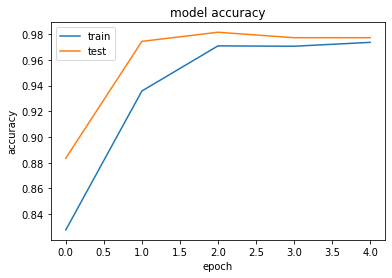

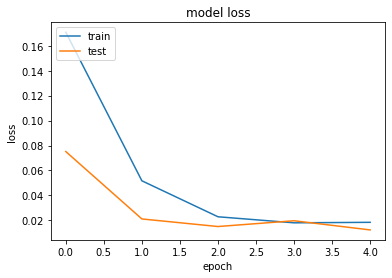

In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


749/749 [==============================] - 86s 114ms/step


In [16]:
pred

array([[2.7510576e-12, 1.4964989e-10, 8.5927077e-10, ..., 8.5516731e-09,
        3.5292949e-09, 1.0000000e+00],
       [2.0255849e-05, 9.0743546e-05, 5.1089170e-05, ..., 1.5661120e-04,
        8.3333405e-05, 9.9997371e-01],
       [2.3567677e-04, 8.0406666e-04, 2.3001432e-04, ..., 6.5240264e-04,
        2.9474497e-04, 9.9966365e-01],
       ...,
       [9.9995798e-01, 3.7340298e-05, 6.9507546e-06, ..., 1.0068116e-05,
        7.0860108e-07, 2.3171687e-10],
       [4.6431593e-33, 1.2284239e-27, 1.3954233e-24, ..., 1.2106196e-21,
        1.5204975e-21, 1.0000000e+00],
       [2.0310283e-04, 1.6227663e-03, 2.5123358e-04, ..., 7.1194768e-04,
        3.3590198e-04, 9.9946833e-01]], dtype=float32)

In [17]:
pred_bool = (pred >0.5)

In [18]:
predictions=[]
labels = train_generator.class_indices

textfile = open("T2_labels.txt", "w")
for element in labels:
    textfile.write(element + "\n")
textfile.close()
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("T2results.csv",index=False)

In [19]:
results

,Filename,Predictions
0,1.png,1.99
1,10.png,1.99
2,100.png,1.99
3,101.png,1.99
4,102.png,1.99
...,...,...
744,95.png,0.024
745,96.png,1.99
746,97.png,0.023
747,98.png,1.99


In [20]:
import PIL
original = PIL.Image.open("data/test/images/100.png")
file_type = original.format

original.save("testing/test.png", format="png")


In [21]:
import PIL
original = PIL.Image.open("data/test/images/100.png") # replace later with image input
file_type = original.format

original.save("testing/test.png", format="png")
##########################
testdata = []
for fname in sorted(os.listdir('testing')):
    if fname == ".DS_Store": continue
            
    subject_data_path = os.path.join('testing', fname)                   
    if not os.path.isfile(subject_data_path): continue          
    testdata.append(fname)
    
df = pd.DataFrame(testdata, columns=['fnames'])
df['fnames']= df['fnames'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255.)
test_g=test_datagen.flow_from_dataframe(
     dataframe= df,
      directory="./testing",
      x_col="fnames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224))
STEP_SIZE_TEST=test_g.n//test_g.batch_size
pred = model.predict_generator(test_g,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_bool = (pred >0.5)
predictions=[]
#labels = train_generator.class_indices
#labels = dict((v,k) for k,v in labels.items())
labels = {}
file1 = open('T2_labels.txt', 'r')
Lines = file1.readlines()
 
count = 0
# Strips the newline character
for line in Lines:
    labels[count] = line.strip()
    count += 1
    
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
    
    
if predictions[0] == '':
    result = 0
else:
    result = float (predictions[0] )
#result = float (predictions[0] ) 

Found 1 validated image filenames.
1/1 [==============================] - 0s 105ms/step


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
predictions[0]

'1.99'

In [23]:
result

1.99

In [24]:
labels

{0: '0.023',
 1: '0.024',
 2: '0.046',
 3: '0.047',
 4: '0.08',
 5: '0.1',
 6: '1.99'}

In [25]:
model

In [26]:
# save the model
filename2 = 'model_t2.h5' 
model.save(filename2)

In [27]:
from keras.models import load_model
# load model
model = load_model('model_t2.h5')

In [33]:
y_test = test_df['labels'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255.)
test_g=test_datagen.flow_from_dataframe(
     dataframe= test_df,
      directory="./data/test/images",
      x_col="fnames",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224)) # to avoid loss of information
STEP_SIZE_TEST=test_g.n//test_g.batch_size
pred = model.predict_generator(test_g,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_bool = (pred >0.5)
predictions=[]
#labels = train_generator.class_indices
#labels = dict((v,k) for k,v in labels.items())
labels = {}
file1 = open('T2_labels.txt', 'r')
Lines = file1.readlines()
 
count = 0
# Strips the newline character
for line in Lines:
    labels[count] = line.strip()
    count += 1
    
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
      
    predictions.append(",".join(l))
y_pred =[]
for i in range(0, len(predictions)):
    if predictions[i] == '':
        y_pred.append(0)
    else:
        listValue  = list(map(float, predictions[i].split(',')))

        y_pred.append(str(max(listValue)))

Found 749 validated image filenames.


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


749/749 [==============================] - 95s 123ms/step


In [34]:
len(y_pred)

749

In [35]:

# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(y_test, y_pred)}")

Accuracy of the classifier is: 0.6542056074766355


In [36]:
from sklearn.metrics import confusion_matrix

# confusion_matrix funnction a matrix containing the summary of predictions
print(confusion_matrix(y_test, y_pred))

[[  0   0   0   0   0   0   0   0]
 [  2   2   2   0   0   0   1  46]
 [  1   7   6   0   0   1   0  35]
 [  0   0   0   0   0   0   0   9]
 [  1   0   0   1   0   0   0   3]
 [  0   0   0   1   0   0   0   8]
 [  1   2   1   0   0   0   0  12]
 [  1  43  49  10   0  11  11 482]]


In [37]:

from sklearn.metrics import mean_squared_error
  # Calculation of Mean Squared Error (MSE)
mean_squared_error([float(i) for i in y_test], [float(i) for i in y_pred])

1.2117828624833111